# Import packages
Note: This notebook can take a while (~5 min) for the first time due to compilation

In [1]:
from juliacall import Main as rms
rms.seval("using PythonCall")
rms.seval("using ReactionMechanismSimulator")
rms.seval("using ReactionMechanismSimulator.Sundials")
from rmgpy.rmg.reactionmechanismsimulator_reactors import to_julia
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


[ Info: Waiting for another process (pid: 19179) to finish precompiling ReactionMechanismSimulator [c2d78dd2-25c4-5b79-bebc-be6c69dd440f]. Pidfile: /Users/mjohns9/.julia/compiled/v1.10/ReactionMechanismSimulator/e5wF8_Hoq3Z.ji.pidfile
[ Info: Precompiling ReactionMechanismSimulator [c2d78dd2-25c4-5b79-bebc-be6c69dd440f]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing ReactionMechanismSimulator [c2d78dd2-25c4-5b79-bebc-be6c69dd440f].
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getpairs :: Tuple{T} where T<:ReactionMechanismSimulator.AbstractReaction` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getsimilarity :: Union{Tuple{T2}, Tuple{T}, Tuple{T, T2}} where {T<:ReactionMechanismSimulator.AbstractSpecies, T2<:ReactionMechanismSimulator.Abstr

If you haven't generate the superminimal RMG mechanism yet, remove the `#` in the following cell and run it. This is an example for docker users.

In [2]:
# ! python /rmg/RMG-Py/rmg.py /rmg/RMG-Py/examples/rmg/superminimal/input.py

## Load the mechanism 
<p style="color: red;"> [User input required] </p>

Load the mechanism file from a `.rms` file
```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/superminimal/rms/chem13.rms")
```
where `mechanism_path` is the path to the generated rms input file

P.S. The same function also works for chemkin files (with thermochemistry and kinetics in the same file):

```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/superminimal/chemkin/chem_annotated.inp"; 
                           spcdict="chemkin/species_dictionary.txt")
```

In [3]:
mechanism_path = "rms/chem13.rms"  # You may change the path to actual mechanism file path

phase_dict = rms.readinput(mechanism_path)
spcs = phase_dict["phase"]["Species"]
rxns = phase_dict["phase"]["Reactions"]

[22:41:39] WARNING: not removing hydrogen atom without neighbors


## Change simulation inputs here
<p style="color: red;"> [User input required] </p>

`initial_conds`: a dictionary containing the initial conditions, where
- `T`: temperature (K)
- `P`: pressure (Pa)
- `H2`: number of moles of H2 
- `O2`: number of moles of O2

`tspan`: the simulation time span ($t_0$, $t_f$) in second. E.g., `(0.0, 0.02)` in this example stands for simulating from 0 to 0.02 second

In [4]:
initial_conds = {"T": 1000.0, "P": 10.0e5, "H2": 0.67, "O2": 0.33}
tspan = (0.0, 0.02)

## Set up and Run the simulation
### Make the ideal gas phase
[No User input required]

`Phase` controls how the thermochemical and kinetic properties are calculated. 

In this example, we are using `IdealGas` and assume treating the system as ideal gases.

In [5]:
ig = rms.IdealGas(spcs, rxns, name="gas")

### Set up the domain
[No User input required]

Domain controls the assumptions made in the simulation (e.g., isothermal, isobaric, adiabatic, etc.)

`ConstantVDomain`: assuming homogeneous constant volume, adiabatic system. The input is the `Phase` and initial conditions. The output is the domain (used to create reactor), y0 the array of initial mole, p the (thermo/kinetic) parameters used of the system

In [6]:
domain, y0, p = rms.ConstantVDomain(phase=ig, initialconds=to_julia(initial_conds))

### Set up the reactor
[No User input required]

In this step, the ordinary differential equations (ODEs) of the system will be constructed based on the defined domain, initial conditions, and parameters.

In [7]:
react = rms.Reactor(domain, y0, tspan, p=p)

### Solve the ODEs
<p style="color: red;"> [User input optional] </p>

The constructed ODEs will be solved.

In [8]:
sol = rms.solve(react.ode,
               rms.CVODE_BDF(),  # You may use a different ODE solver. This is the one also used in Cantera
               abstol=1e-16,  # You may tighter the tolerance with a cost of more computational time
               reltol=1e-8,  # You may tighter the tolerance with a cost of more computational time
               )

### Set up simulation object
[No User input required]

Gathering the simulation results and make it ready to be read, output, and visualized

In [9]:
sim = rms.Simulation(sol, domain)

# Perform different types of sensitivity analyses here

# Transitory sensitivity anaylsis

## Plot transitory sensitivity of rate coefficients
<p style="color: red;"> [User input optional] </p>

Plot the transitory sensitivity of specified species to rate coefficients. You may change the following parameters
- `spc`: The label of the species to perform sensitivity analysis for.
- `t`: time point to perform transitory sensitivity analysis (in second). You can try different `t` between the time span `tspan` you defined.
- `N`: number of reactions to show in the plot
- `tol`: only show if the sensitivities are larger than `tol`

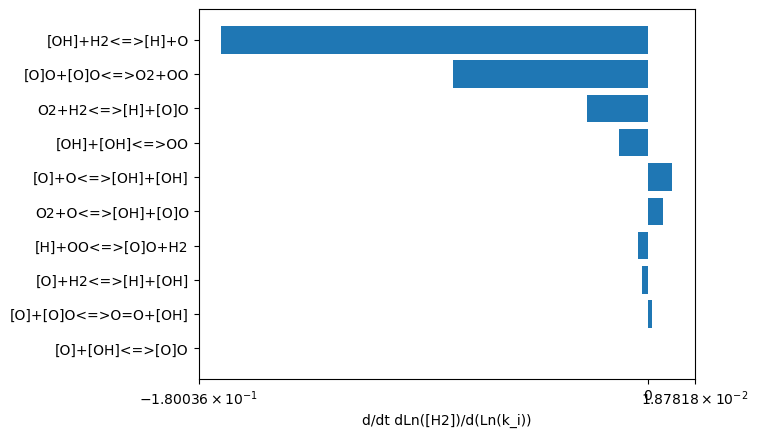

In [10]:
spcname = "H2"
t = 0.02
N = 10
tol = 1e-5
rms.plotrxntransitorysensitivities(sim, spcname, t, N=N, tol=tol)

## Plot transitory sensitivity of thermochemistry
<p style="color: red;"> [User input optional] </p>

Plot the transitory sensitivity of specified species to Gibbs free energy of formation. You may change the following parameters
- `spc`: The label of the species to perform sensitivity analysis for.
- `t`: time point to perform transitory sensitivity analysis (in second). You can try different `t` between the time span `tspan` you defined.
- `N`: number of reactions to show in the plot
- `tol`: only show if the sensitivities are larger than `tol`

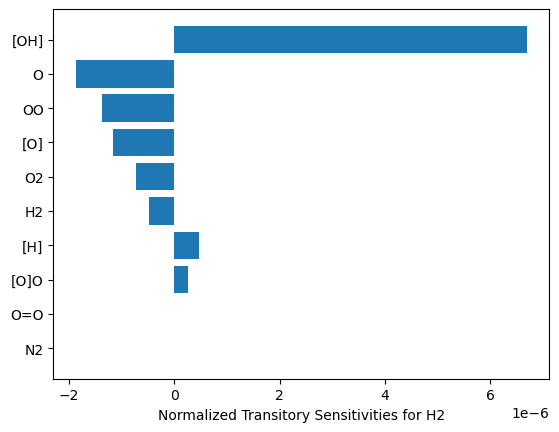

In [11]:
spc = "H2"
t = 0.02
N = 10
tol = 1e-5
rms.plotthermotransitorysensitivities(sim, spc, t, N=N, tol=tol)

# Adjoint sensitivity analysis
<p style="color: red;"> [User input optional] </p>

Solve the adjoint sensitivities for specified species. You may change the following parameters
- `spc`: The label of the species to solve adjoint sensitivities for

In [12]:
spc = "H2"
dps = rms.getadjointsensitivities(sim,
                                  spc,
                                  rms.CVODE_BDF(),  # You may use a different ODE solver. This is the one also used in Cantera
                                  abstol=1e-6,  # You may tighter the tolerance with a cost of more computational time
                                  reltol=1e-3,  # You may tighter the tolerance with a cost of more computational time
                                 )

## Plot adjoint sensitivities of reaction rates
<p style="color: red;"> [User input optional] </p>

This plots the adjoint sensitivity of `spc` to reaction rates at the final time point in the specified `tspan`. The sensitivity is shown as $\frac{\mathrm{dln}N_{H_2}}{\mathrm{dln}k_f}$, where $\mathrm{ln}$ refers to the natural log, $N_{H_2}$ refers to the moles of $H_2$, and $k_f$ refers to the forward rate of each reactions.

You may change the following parameters
- `N`: number of reactions to show in the plot
- `tol`: only show if the sensitivities are larger than `tol`

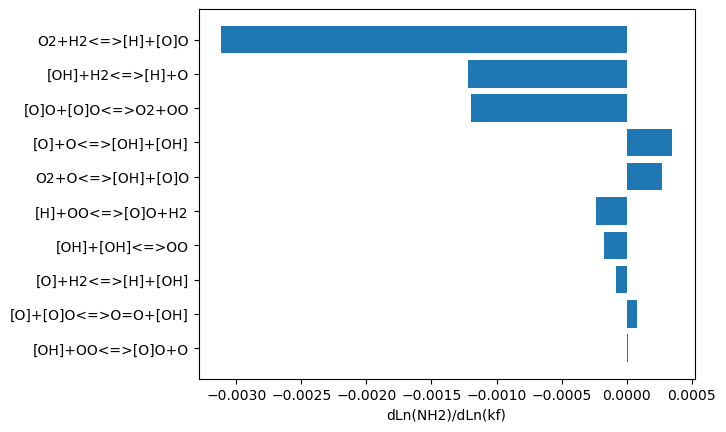

In [13]:
N = 10
tol = 1e-5
rms.plotrateadjointsensitivities(sim, spc, dps, tol=tol, N=N)

## Plot adjoint sensitivities of thermochemistry
<p style="color: red;"> [User input optional] </p>

This plots the adjoint sensitivity of `spc` to Gibbs free energy of formation at the final time point in the specified `tspan`. The sensitivity is shown as $\frac{\mathrm{dln}N_{H_2}}{\mathrm{d}G}$, where $G$ refers to the Gibbs free energy of formation of each species

You may change the following parameters
- `N`: number of reactions to show in the plot
- `tol`: only show if the sensitivities are larger than `tol`

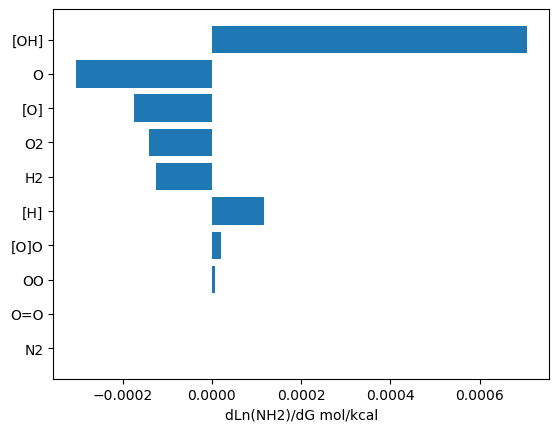

In [14]:
N = 10
tol = 1e-5
rms.plotthermoadjointsensitivities(sim, spc, dps, N=N, tol=tol)

# Threaded forward sensitivities
<p style="color: red;"> [User input optional] </p>
Solve the threaded version of forward sensitivities. Internally, it solves the ODE equations normally, and then solve the sensitivity equations for each parameter in parallel.

In [15]:
sol_tfs = rms.threadedsensitivities(react,
                                    odesolver=rms.CVODE_BDF(),   # You may use a different ODE solver. This is the one also used in Cantera
                                    senssolver=rms.CVODE_BDF(),   # You may use a different ODE solver for the sensitivity equations. This is the one also used in Cantera
                                    odekwargs={rms.Symbol("abstol"): 1e-18, rms.Symbol("reltol"): 1e-6,}, # You may tighter the tolerance with a cost of more computational time
                                    senskwargs={rms.Symbol("abstol"): 1e-6, rms.Symbol("reltol"): 1e-3,} # You may tighter the tolerance with a cost of more computational time
                                   );

### Set up simulation object
[No User input required]

Gathering the simulation results and make it ready to be read, output, and visualized

In [16]:
sim_tfs = rms.Simulation(sol_tfs, domain)

## Plot threaded forward sensitivities of reaction rates
<p style="color: red;"> [User input optional] </p>
This plots the threaded forward sensitivities of `spc` to reaction rates. For sensitivities of `spc` to each reaction rates, the function searches for maximum value in time and displays it. This waives the needs for user to manually do so. The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{dln}k_f}$, where $\mathrm{ln}$ refers to the natural log, $[H_2]$ refers to the concentration of $H_2$, and $k_f$ refers to the forward rate of each reactions.

You may change the following parameters
- `spc`: The label of the species to plot sensitivity analysis for
- `N`: number of reactions to show
- `tol`: only show if the sensitivities are larger than `tol`

Text(0.5, 0, 'dLn([H2])/d(Ln(k_i))')

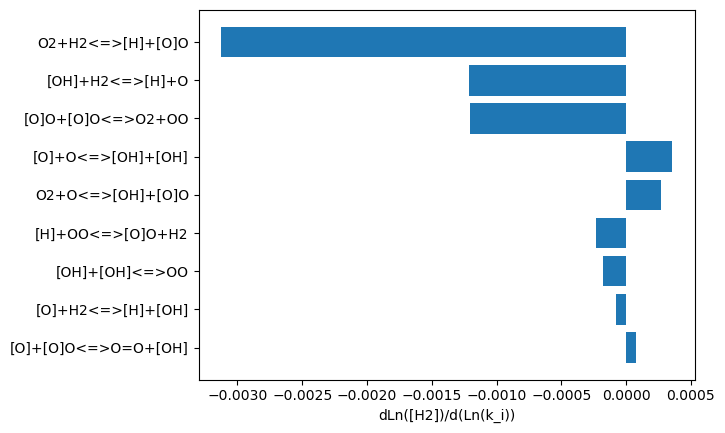

In [17]:
spc = "H2"
N = 10
tol = 1e-5
rms.plotmaxrateforwardsensitivity(sim_tfs, spc, N=N, tol=tol)

## Plot threaded forward sensitivities of thermochemistry
<p style="color: red;"> [User input optional] </p>
This plots the threaded forward sensitivities of `spc` to Gibbs free energy of formation. For sensitivities of `spc` to each Gibbs free energy of formation, the function searches for maximum value in time and displays it. This waives the needs for user to manually do so. The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{d}G}$, where $G$ refers to the Gibbs free energy of formation of each species.

You may change the following parameters
- `spc`: The label of the species to plot sensitivity analysis for
- `N`: number of reactions to show
- `tol`: only show if the sensitivities are larger than `tol`

Text(0.5, 0, 'dLn([H2])/d(G_i) mol/kcal')

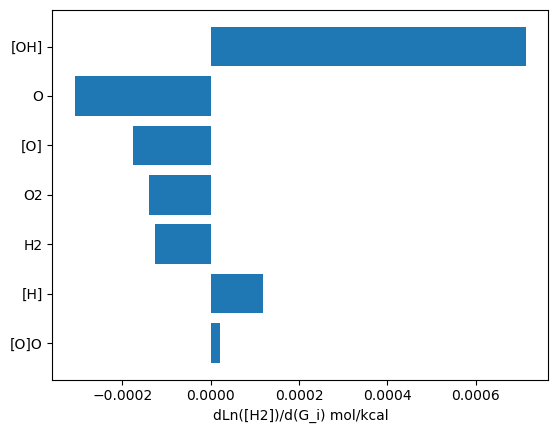

In [18]:
spc = "H2"
N = 10
tol = 1e-5
rms.plotmaxthermoforwardsensitivity(sim_tfs, spc, N=N, tol=tol)

# Traditional forward sensitivities

### Set up the reactor
[No User input required]

In this step, the ordinary differential equations (ODEs) and the forward sensitivity equations of the system will be constructed based on the defined domain, initial conditions, and parameters.

In [19]:
react_fs = rms.Reactor(domain, y0, tspan, p=p, forwardsensitivities=True)

### Solve the ODEs
<p style="color: red;"> [User input optional] </p>

The constructed ODEs and forward sensitivity equations will be solved.

In [20]:
sol_fs = rms.solve(react_fs.ode,
                  rms.CVODE_BDF(),   # You may use a different ODE solver. This is the one also used in Cantera
                  abstol=1e-16, # You may tighter the tolerance with a cost of more computational time
                  reltol=1e-8, # You may tighter the tolerance with a cost of more computational time
                 )

### Set up simulation object
[No User input required]

Gathering the simulation results and make it ready to be read, output, and visualized

In [21]:
sim_fs = rms.Simulation(sol_fs, domain)

## Plot traditional forward sensitivities of reaction rates
<p style="color: red;"> [User input optional] </p>
This plots the traditional forward sensitivities of `spc` to reaction rates. For sensitivities of `spc` to each reaction rates, the function searches for maximum value in time and displays it. This waives the needs for user to manually do so. The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{dln}k_f}$, where $\mathrm{ln}$ refers to the natural log, $[H_2]$ refers to the concentration of $H_2$, and $k_f$ refers to the forward rate of each reactions.

You may change the following parameters
- `spc`: The label of the species to plot sensitivity analysis for
- `N`: number of reactions to show
- `tol`: only show if the sensitivities are larger than `tol`

Text(0.5, 0, 'dLn([H2])/d(Ln(k_i))')

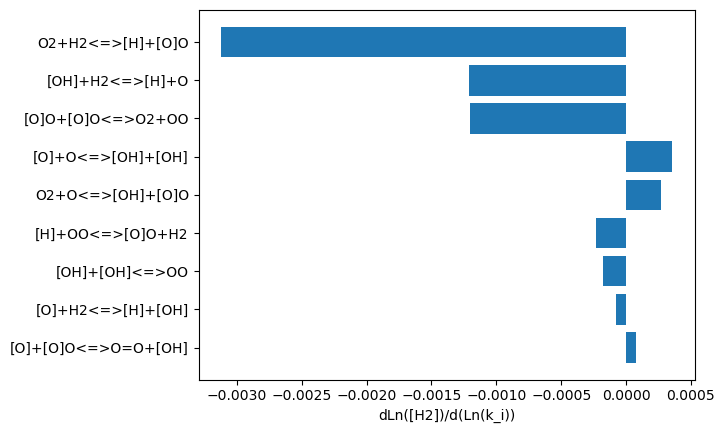

In [22]:
spc = "H2"
N = 10
tol = 1e-5
rms.plotmaxrateforwardsensitivity(sim_fs, spc, N=N, tol=tol)

## Plot traditional forward sensitivities of thermochemistry
<p style="color: red;"> [User input optional] </p>
This plots the traditional forward sensitivities of `spc` to Gibbs free energy of formation. For sensitivities of `spc` to each Gibbs free energy of formation, the function searches for maximum value in time and displays it. This waives the needs for user to manually do so. The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{d}G}$, where $G$ refers to the Gibbs free energy of formation of each species.

You may change the following parameters
- `spc`: The label of the species to plot sensitivity analysis for
- `N`: number of reactions to show
- `tol`: only show if the sensitivities are larger than `tol`

Text(0.5, 0, 'dLn([H2])/d(G_i) mol/kcal')

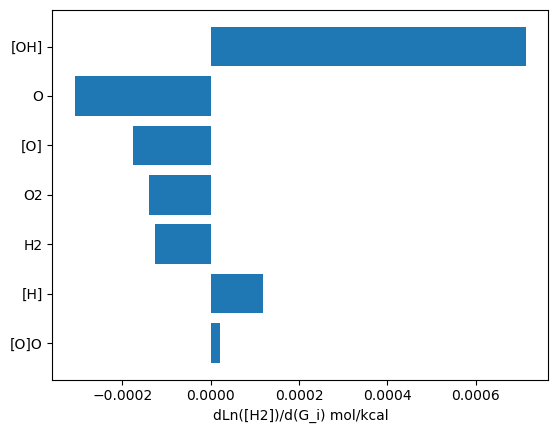

In [23]:
spc = "H2"
N = 10
tol = 1e-5
rms.plotmaxthermoforwardsensitivity(sim_tfs, spc, N=N, tol=tol)